# Preprocessing Notebook

## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from PIL import Image
import hashlib

from sklearn.model_selection import train_test_split

from collections import Counter

In [ ]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [ ]:
print(X.shape, y.shape)

## Remove duplicates

In [ ]:
shrek_idx = 13302
rick_idx = 13758

In [ ]:
to_remove_idx = []
for i, img in enumerate(X):
    if np.array_equal(img, X[shrek_idx]) or np.array_equal(img, X[rick_idx]):
      to_remove_idx.append(i)

X = np.delete(X, to_remove_idx, axis=0)
y = np.delete(y, to_remove_idx, axis=0)

In [ ]:
# Compute hash for each image to identify unique images
unique_hashes = {}
unique_indices = []

for idx, img in enumerate(X):
    img_hash = hashlib.md5(img.tobytes()).hexdigest()

    if img_hash not in unique_hashes:
        # If this hash is not already in the unique set, add it
        unique_hashes[img_hash] = idx
        unique_indices.append(idx)

# Extract unique images and labels using unique indices
unique_images = X[unique_indices]
unique_labels = y[unique_indices]

print(unique_images.shape)


(11951, 96, 96, 3)


In [ ]:
del X
del y
del to_remove_idx

In [ ]:
np.savez_compressed('data_unique.npz',
                    images=unique_images, labels=unique_labels)

## Augmentation

The cells that follow contain my attempt of pre-augmenting the dataset. This idea was subsequently discarded, replaced with on-demand augmentation using Keras layers. This resulted in reduced load on the RAM and more challenging transformations for the network.

In [ ]:
# Apply only some of the transformations not to make a gigantic dataset (so that RAM will contain it entirely)
trans = [[0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 2, 5], [0, 1, 2, 6]]
transformations1 = [0, 1, 2, 3]
transformations2 = [0, 1, 2, 4]
transformations3 = [0, 1, 2, 5]
transformations4 = [0, 1, 2, 6]

# Augmentation pipeline
def augment_image(image, label):
    augmented_dataset = tf.data.Dataset.from_tensors((image, label))

    transformations = [
        lambda img: tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)),
        lambda img: tf.image.random_brightness(img, max_delta=0.5),
        lambda img: tf.image.random_contrast(img, lower=0.2, upper=2.0),
        lambda img: tf.image.random_hue(img, max_delta=0.5),
        lambda img: tf.concat([img[:, :, :2], tf.zeros_like(img[:, :, :1])], axis=-1),
        lambda img: tf.concat([img[:, :, :1], tf.zeros_like(img[:, :, :1]), img[:, :, 2:]], axis=-1),
        lambda img: tf.concat([tf.zeros_like(img[:, :, :1]), img[:, :, 1:]], axis=-1),
    ]

    # Apply selected transformations
    for t in trans:
        augmented_image = transformations[t[0]](image)
        augmented_image = transformations[t[1]](augmented_image)
        augmented_image = transformations[t[2]](augmented_image)
        augmented_image = transformations[t[3]](augmented_image)
        augmented_dataset = augmented_dataset.concatenate(tf.data.Dataset.from_tensors((augmented_image, label)))

    return augmented_dataset

def apply_augmentation(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    augmented_dataset = dataset.flat_map(augment_image)
    return augmented_dataset

In [ ]:
augmented_dataset = apply_augmentation(X, y)

In [ ]:
# Convert augmented_dataset to numpy arrays
augmented_images = []
augmented_labels = []

for image, label in augmented_dataset:
    augmented_images.append(image.numpy())
    augmented_labels.append(label.numpy())

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

### Visualize augmented images

2024-11-12 23:41:46.869898: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


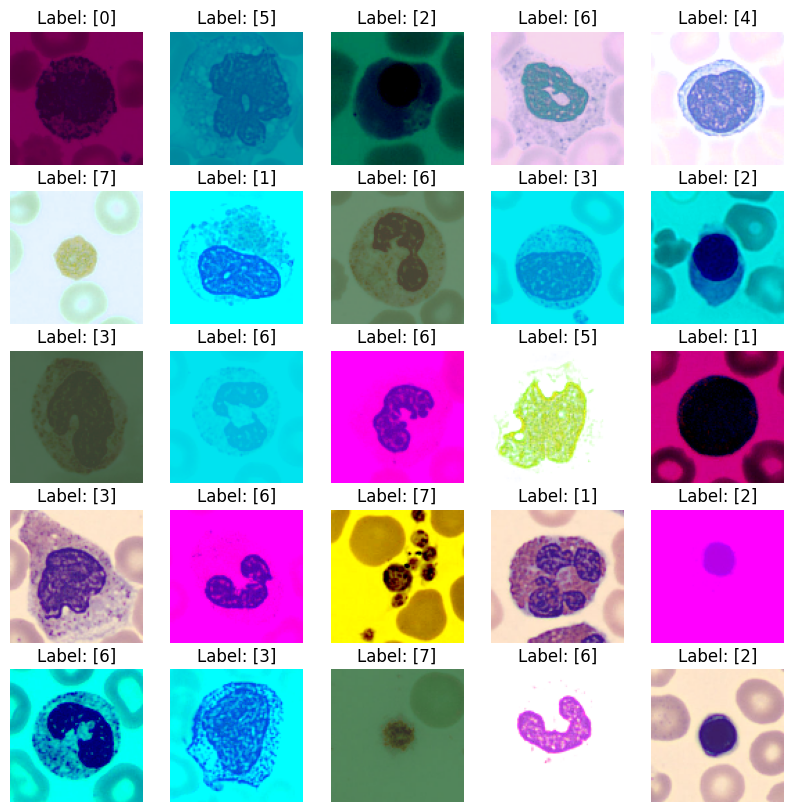

In [ ]:
def show_augmented_images(augmented_dataset, num_images=25):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(augmented_dataset.shuffle(buffer_size=10000).take(num_images)):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
    plt.show()

show_augmented_images(augmented_dataset)

In [ ]:
del unique_images
del unique_labels

Check that original images are included

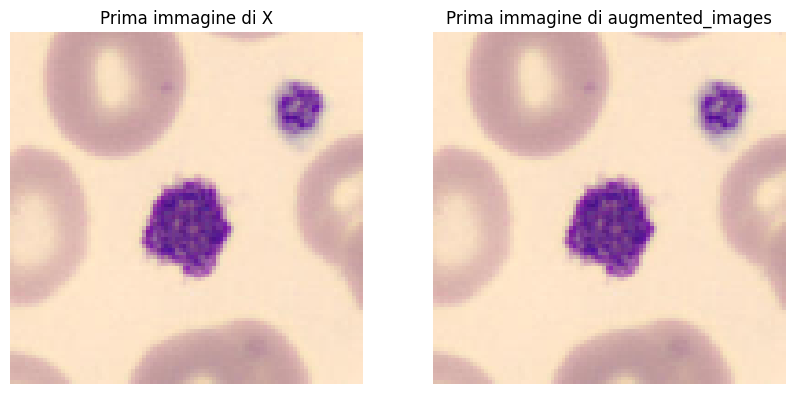

In [ ]:
# Mostra la prima immagine dell'array numpy X
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X[0])
plt.title("Prima immagine di X")
plt.axis("off")

# Mostra la prima immagine dell'array numpy augmented_images
plt.subplot(1, 2, 2)
plt.imshow(augmented_images[0])
plt.title("Prima immagine di augmented_images")
plt.axis("off")

plt.show()

## Splitting and saving

Splitting was originally done in this notebook to reduce load on the RAM. The operation was then integrated as an on-demand operation in the training notebook.

In [ ]:
# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(augmented_images, augmented_labels,
                                                                      test_size=0.15, random_state=42, stratify=augmented_labels)

print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of validation labels: {len(val_labels)}")

Number of training images: 10158
Number of validation images: 1793
Number of training labels: 10158
Number of validation labels: 1793


Check that splitting mantains original dataset proportions

In [ ]:
y_train = np.ravel(train_labels)
y_val = np.ravel(val_labels)

train_class_counts = dict(Counter(y_train))
print("Distribuzione delle classi nel training set:", train_class_counts)

val_class_counts = dict(Counter(y_val))
print("Distribuzione delle classi nel validation set:", val_class_counts)

train_percentages = {label: count / len(y_train) * 100 for label, count in train_class_counts.items()}
val_percentages = {label: count / len(y_val) * 100 for label, count in val_class_counts.items()}

print("Percentuale di ciascuna classe nel training set:", train_percentages)
print("Percentuale di ciascuna classe nel validation set:", val_percentages)

Distribuzione delle classi nel training set: {np.uint8(0): 722, np.uint8(5): 843, np.uint8(7): 1397, np.uint8(1): 1852, np.uint8(6): 1980, np.uint8(2): 922, np.uint8(4): 722, np.uint8(3): 1720}
Distribuzione delle classi nel validation set: {np.uint8(3): 303, np.uint8(7): 246, np.uint8(6): 350, np.uint8(1): 327, np.uint8(5): 149, np.uint8(0): 128, np.uint8(2): 163, np.uint8(4): 127}
Percentuale di ciascuna classe nel training set: {np.uint8(0): 7.107698365820044, np.uint8(5): 8.298877731836976, np.uint8(7): 13.752707225831855, np.uint8(1): 18.23193542035834, np.uint8(6): 19.492025989367985, np.uint8(2): 9.076589879897618, np.uint8(4): 7.107698365820044, np.uint8(3): 16.932467021067136}
Percentuale di ciascuna classe nel validation set: {np.uint8(3): 16.899051868377022, np.uint8(7): 13.720022308979365, np.uint8(6): 19.520356943669828, np.uint8(1): 18.237590630228667, np.uint8(5): 8.310094813162298, np.uint8(0): 7.138873396542109, np.uint8(2): 9.090909090909092, np.uint8(4): 7.0831009481

In [ ]:
np.savez_compressed('data_prep_unbalanced.npz',
                    train_images=train_images, train_labels=train_labels,
                    val_images=val_images, val_labels=val_labels)